In [1]:
from scipy.stats import norm
import scipy.interpolate as inter
import numpy as np
import random
import scipy.integrate as integ
import matplotlib.pyplot as plt
import copy
import time as tm

In [172]:
"""voterSimulator"""
"""Modeling How Interactions within a Population Change the Opinion Distribution of a Population"""
"""Final Project ECON 380"""
"""Authors: Brian Gould and Jack Dunne"""
"""Last Update: 12/11/2020 at 6:36pm"""

def charEq(lims = [0,1], switch = 0, xrange = [-10, 10], sd = 2*np.pi):
    """
    Returns a function y = f(x) that is the solution to the differential equation: y' = C(y-a)*(y-b) 
    You must provide initial conditions
    
    Parameters: 
    -------------------------------------------
    lims: array [a, b];  where a, b are constants in the equation in the discription 
    switch: float; the x value where y = (a+b)/2
    xrange: array [xmin, xmax]; the range for which you want the function to provide stable solutions to the differential equation
    sd: float; sd = c/2pi 
    
    Returns: function; returns a function object y = f(x) that is the solution to the differential equation y' = C(y-a)*(y-b) that is stable within the xrange given in Parameters
    
    Graph of the solution will look like this: 
    -------------------------
    a.....            
             . 
               . 
                s 
                 .
                   .
                       ......b
    --------------------------
    At a, y = a
    At b, y = b
    At s, (x,y) = (switch, (a+b)/2)
    The function will flip around s if xrange[0] > xrange[1] (I think, I am not sure. Either way it is better to transform the function after it has been created)
    
    
    """
    def dydx(y, x): 
        return (2*np.pi/sd)*(y-lims[0])*(y-lims[1])
    y0 = sum(lims)/2
    xsp = np.linspace(switch ,xrange[1], 101)
    xsm = np.linspace(xrange[0], switch, 101)[::-1]
    ysp = np.array(integ.odeint(dydx, ( y0, y0 ), xsp ))[:,1][1::]
    ysm = np.array(integ.odeint(dydx, ( y0, y0 ), xsm ))[:,1][::-1]
    xs = np.concatenate((xsm[::-1], xsp[1::]))
    ys = np.concatenate((ysm, ysp))
    return inter.InterpolatedUnivariateSpline(xs, ys)

def interact(p1,p2, plot = "false", axGiven = 0):
    """
    Simulates an interaction between 2 people. Based off of parameters given in the Voter class, each voter's opinion may change
    
    Parameters: 
    -------------------
    p1: Voter; one of the poeple in the interaction
    p2: Voter; the other person in the interaction. Order of p1, p2 does not matter
    plot: string; if plot = "true", a plot of the interaction is shown
    axGiven: plotting axis; axis on which to plot the interaction; if none is given and plot = "true", a new figure and plot will be created. 
    
    Returns: nothing 
    """
    interactor1 = copy.deepcopy(p1)
    interactor2 = copy.deepcopy(p2)
    if (plot == "true" and axGiven == 0): 
        fig = plt.figure(figsize=(10,8))
        ax = fig.add_subplot(1,1,1)
        axGiven = ax
        axGiven.set_title("Opinion vs x")
        axGiven.set_xlabel('x')
        axGiven.set_ylabel('Opinion')
    p1.interaction(interactor2, plot = plot, axGiven = axGiven)
    p2.interaction(interactor1, plot = plot, axGiven = axGiven) 
    
    

opCharEq = charEq() 
    #creates a funtion that is used to determine how people's opinion changes based on interactions with news and other people 
    #It is important to do this instead of calling charEq() every time we want to use that function so that the computer onoly has to solve the differential equation once


In [173]:
class News:    
    """Represents a piece of media relevant to the issue in the simulation"""
    def __init__(self, opinion = .5,  influence = .5, credibility = .5,): 
        """
        Parameters: 
        ----------------------------------
        opinion: float between 0 and 1; represents the political stance the news takes
        influence: float between 0 and 1; represents how convincing the news article is. This will affect voters of all education levels similarly
        credibility: float between 0 and 1; represents how credible the news is. Less credible sources will influence voters with higher education less
        """
        self.opinion = opinion  
        self.credibility = credibility
        self.influence = influence
        self.rt = 0 #Unused at the moment
        self.like = 0 #Unused at the moment
        self.reprimand = 0 #Unused at the moment
        
    def rt_(self):
        """
        Unused function
        counts the number of shares or "retweets" of the news
        """
        self.rt = self.rt +1    

class Voter:
    """
    The voter class represents 1 individual person. This person has atributes and an opinion that can be changed after interactions with News classes and other Voter classes
    The voters and news that the person interacts with will be refered to as an "influence"
    """
    def __init__(self, opinion, educ, wtl, formed, social, influence, formingRate = .01):
        """
        Parameters: 
        ----------------------------
        opinion: float between 0 and 1; represents the voter's opinion on 1 specific topic
        educ: float between 0 and 1; education level on the topic, from 0 to 1. (.4 = average highschool grad, .6 = average college grad,.8 and above: expert in the field)
        wtl: float; represents a person's "willingness to listen radius" if an influence has an opinion that is further away from the voters own opinion than the value of wtl
            will not affect the voter's opinion. For example, an influence with an opinion of .9 will not affect the opinion of a voter with opinion .3 and wtl = .2 since
            .9 is not in the range of [.3-.2, .3+.2]
        formed: float between 0 and 1; represents how formed a voter's views are. The higher the value of formed is, the less any influence will affect him. Each time the 
            voter interacts, formed increases. 
        social: float between 0 and 1; how likely a voter is to interact with another voter in 1 round of a simulation. 0 will cause a voter to never interact with other
            voters. 1 will cause the voter to interact with another voter every round. 
        influence: float between 0 and 1; how likely the voter is to change another voter's opinion. Higher values make the voter more likely to influence other voters in 
            any given interaction
        formingRate (Optional): float between 0 and 1; represents how quickly the voter will form an opinion. Higher values cause self.formed to increase faster in each interaction
        
        """
        self.opinion = opinion #0-1 value range indicating political beliefs
        self.educ = educ 
        self.wtl = wtl #willingness to listen - how stubborn preferences are
        self.formed = formed  
        self.social = social #probability a person will have an interaction in a certain round 
        self.influence = influence #how influential this person is
        self.formingRate = formingRate
        self.mediaList = [] 
        self.friendList = [] #friends on a social media page 

    #returns a numerical value for the likelihood of being influenced
    #could potentially incorporate some machine learning concepts to formulate an optimal equation
    def voterTraits(self): 
        """
        Prints a string with the voter's current characteristics 
        
        Paramaters: none
        
        Returns: string; describes the voter's current characteristics 
        """
        return ("opinion: {}, education: {}, wtl: {}, formed: {}, influence: {}".format(self.opinion, self.educ, self.wtl, self.formed, self.influence))
    
    def news_interaction(self, influencer, plot = "false", axGiven = 0): 
        """ 
        Simulates how the voter's opinion will change based on a piece of news media based on characeristics of the news, the voter, and random other factors. 
        
        Partameters: 
        ------------------------------------------
        influencer: News object; the news that the voter will interact with
        plot (optional): string; if plot = "true", a plot of the interaction will be created
        axGiven (optional): plot axis; if given and plot = "true", the plot will be placed on the given axis
        
        Returns: nothing 
        
        """
        def influence_profile(x):     
            """
            Based on the equation for x, which represents how likely the voter is to have their opinion changed, influence_profile returns the voter's new opinion. 
            The voter's new opinion is garenteed to be between the voter's origional opinion and the influencer's opinion
            
            Parameters: 
            ------------------
            x: float between -10 and 10; -10 indicates no change in opinion. 10 indicates alligning the opinion totally with the other's.
            
            Retruns: float between 0 and 1; the voter's new opinion 
            """
            return self.opinion + (influencer.opinion-self.opinion)*(1-opCharEq(x))
        
        if (plot == "true"):
            #This section of code plots the interaction if plot = "true"
            xs = np.linspace(-10, 10, 100)
            if (axGiven != 0): 
                axGiven.plot(xs, influence_profile(xs), label = "Opinion as a function of x")
                axGiven.legend()
            else:     
                fig = plt.figure(figsize=(10,8))
                ax = fig.add_subplot(1,1,1)
                ax.plot(xs, influence_profile(xs), label = "Opinion as a function of x")
                ax.legend()
        
        x = max(min(20*random.random()*influencer.influence*(1-self.formed)*(1-max(self.educ-influencer.credibility, 0))-10, 10), -10)
            #represents how effective the influence was at changing the voter's opinion
        
        if (np.abs(self.opinion-influencer.opinion) <= self.wtl):
            #if the influencer's opinion is within the voter's willing to listen radius, this changes the voter's opinion based on x
            self.opinion = influence_profile(x)
#        if (np.abs(self.opinion-influencer.opinion)<=.05): 
#            self.mediaList.append(influencer)
#            influencer.rt_()
        self.formed = min(self.formed + self.formingRate*np.random.random(), 1) #increases how formed the voter's opinion is after the interaction 

    def interaction(self, influencer, plot = "false", axGiven = 0):
        """ 
        Simulates how the voter's opinion will change based on an interaction with another voter based on characeristics of the other voter, the voter, and random other factors. 
        This method will change the voter's opinion characteristic. 
        
        Partameters: 
        ------------------------------------------
        influencer: Voter object; the news that the voter will interact with
        plot (optional): string; if plot = "true", a plot of the interaction will be created
        axGiven (optional): plot axis; if given and plot = "true", the plot will be placed on the given axis
        
        Returns: nothing 
        
        """
        def influence_profile(x):
            """
            Based on the equation for x, which represents how likely the voter is to have their opinion changed, influence_profile returns the voter's new opinion. 
            The voter's new opinion is garenteed to be between the voter's origional opinion and the influencer's opinion

            Parameters: 
            ------------------
            x: float between -10 and 10; -10 indicates no change in opinion. 10 indicates alligning the opinion totally with the other's.

            Retruns: float between 0 and 1; the voter's new opinion 
            """
            return self.opinion + (influencer.opinion-self.opinion)*(1-opCharEq(x))
        
        x = max(min(20*random.random()*influencer.influence*(1-self.formed)*(1-max(0, self.educ-influencer.educ))-10, 10), -10)
            #represents how effective the influence was at changing the voter's opinion
        
        if (plot == "true"):
            #this section of code plots the interaction if plot = "true"
            xs = np.linspace(-10, 10, 100)
            if (axGiven != 0): 
                axGiven.plot(xs, influence_profile(xs), label = "Opinion as a function of x")
                axGiven.legend()
            else:
                fig = plt.figure(figsize=(10,8))
                ax = fig.add_subplot(1,1,1)
                ax.plot(xs, influence_profile(xs), label = "Opinion as a function of x")
                ax.legend()

        if (np.abs(self.opinion-influencer.opinion) <= self.wtl):
            #if the influencer's opinion is within the voter's willing to listen radius, this changes the voter's opinion based on x
            self.opinion = influence_profile(x)
            if (self.opinion<0 or self.opinion>1): 
                print("ERROR: Opinion below 0")
            
#        if (np.random.random()<=.5): #This code slows down the program a ton to the point it is unusable
#            self.friendList.append(influencer)
        
        self.formed = self.formed + self.formingRate*np.random.random()
            #increases how formed the voter's opinion is after the interaction
        
        
        if (plot == "true"): 
            #this secion of code plots the viters new opinion if plot = "true"
            if (axGiven != 0): 
                axGiven.plot(x, self.opinion, "o", label = "New opinion")
                axGiven.legend()
            else:
                ax.plot(x, self.opinion, "o", label = "New opinion") 
                ax.legend()
        self.formed = min(self.formed + self.formingRate*np.random.random(), 1)     
        
def society_generator(population,  
                      opinion_msd = (.5, .175),
                      opinions = "normal", 
                      opinionPeaks = 1, 
                      educ_scale = "off", 
                      wtl_msd = "off", 
                      formed_scale = "off", 
                      social_msd = "off", 
                      influence_msd = "off"):
    """
    society_generator generates a list of Voter objects based on the distribution specified by the input paramaters. 
    
    Paramaters: 
    -----------------------------------
    population: int; number of voters in the society
    opinion_msd (optional): array, either of shape [m,sd] or [[m1,sd1], [m2, sd2],...]; represents the mean of the opinion distribution
        if opinions == "spread": array should have the form [m, sd]. m and sd represent the mean and standard deviation of opinions of the population that will be 
            generated with a normal distribution
        if opinions == "n-modal": array should have the form [[m1,sd1], [m2, sd2],...]. m1, sd1 represent the mean and standard deviation of the first normal distribution. 
            m2, sd2 represent the mean and standard deviation of the second normal distribution, and so on
        if opinions == "bianary": array should have the form [m, sd]. m and sd represent the mean and standard deviation of opinions of the population that will be 
            generated with a charactoristic equation-like distribution. The distribution will follow the form of the function outlined in charEq()
        if opinions == "uniform": opinions_msd does not affect the distribution and can be left blank
    opinions (optional): string; describes how the opinions of the society will be distributed. 
        if opinions == "normal": Opinions will be normally distributed
        if opinions == "n-modal": Opinions will be a superposition of normal distributions 
        if opinions == "bianary": Opionions will be distributed so that it is likely that opinions will be either close to 0 or close to 1. The distributions will be defined 
            by the function outlined in charEq
        if opinions == "uniform": Opinions will be uniformily distributed
    opinionPeaks (optional): int greater than 0; if opinions == "n-modal", this is the number of peaks that the distribution will have
    educ_scale (optional): float; represents how educated the population is. Education is represented by a gamma distribution with k = 3, and this is the scale of the distribution
        if educ_scale == "off", all voters will have the maximum education and hence the model will not take education into account
    wtl_msd (optional): array (m, sd); represents the mean and standard deviation that the willingness to listen values of the population will have
        if wtl_msd == "off", all voters will have wtl = 1 and the willingness to listen radius will not be taken into account in the model
    formed_scale (optional): float; represents how formed the population's opinions are. formed is determined by a gamma distribution with k = 3, and this is the scale of the distribution
        if formed_scale == "off", all voters will have formed = 0
    social_msd (optional): array (m, sd); represents the mean and standard deviation that the social values of the population will have
        if social_msd == "off", all voters will have social = 1 and hence all voters will interact everyh round
    influence_msd (optional): array (m, sd); represents the mean and standard deviation that the influence values of the population will have
        if influence_msd == "off", all voters will have influence = 1 and hence the model will not take into account people's influence
        
    Returns: list; returns a list of voter objects with properties specified by the parameters
    

    """
    
    
    people = []
    for i in range(population):
        if (opinions == "normal"): 
            opinionSpread = min(1, max(np.random.normal(opinion_msd[0], opinion_msd[1]), 0))
        if (opinions == "n-modal"): 
            mode = np.random.randint(0, opinionPeaks)
            opinionSpread = min(1, max(np.random.normal(opinion_msd[mode][0], opinion_msd[mode][1]), 0))      
        if (opinions == "bianary"): 
            func = charEq(xrange = [0,1], switch = opinion.msd[0], sd = opinion_msd[1])
            opinionSpread = func(np.random.random())
        if (opinions == "uniform"): 
            opinionSpread = np.random.random()    
        opinion = opinionSpread
        if (educ_scale == "off"): 
            educ = .5
        else: 
            educ = min(np.random.gamma(3, scale=educ_scale, size=1), 1)
        if (wtl_msd == "off"): 
            wtl = 100
        else: 
            wtl = np.random.normal(wtl_msd[0], wtl_msd[1])
        if (formed_scale == "off"): 
            formed = 0 
        else:    
            formed = min(np.random.gamma(3, scale= formed_scale, size=1), 1)
        if (social_msd == "off"): 
            social = 1
        else: 
            social = min(1, max(np.random.normal(social_msd[0], social_msd[1]), 0))
        if (influence_msd == "off"):
            influence = 1
        else: 
            influence = np.random.normal(.5, .2)
        people.append(Voter(opinion, 
                            educ,
                            wtl, #should be based on political stance, ie how radical their beliefs are - more rad = less wtl
                            formed,
                            social,  #go over these to make sure they give the correct values that you want for your population
                            influence))
    return people 
#next, test that the above np methods give you the things that you want

class NewsSpace: 
    """ 
    Stores the collection of all news available to voters
    """
    def __init__(self):
        self.newsList = []
    
    def add1News(self, news):
        """ 
        adds a specific news object to the news space
        
        Parameters: 
        news: News object; the news item to be added to the news space
        
        Returns: nothing
        """
        self.newsList.append(news)
        
    def addNews(self, num_of_news = 1, opinion_msd = (.5, .2), influence_msd = (.5, .2), credibility_msd = (.5, .2), opinions = "spread"): 
        """ 
        Adds multiple news articles to the news space according to the distribution specified in the patameters
        
        Parameters: 
        ------------------------
        num_of_news: int greater than 0; number of news articles to add to the news space
        opinion_msd: array [m, sd]; array should have the form [m, sd]. m and sd represent the mean and standard deviation of opinions of the news that will be 
            generated with a normal distribution
        influence_msd: array [m, sd]; m and sd represent the mean and standard deviation of influence of the news that will be 
            generated with a normal distribution
        credibility_msd: array [m, sd]; m and sd represent the mean and standard deviation of credibility of the news that will be 
            generated with a normal distribution
            
        Returns: nothing
        """
        for i in range(0, num_of_news): 
            if (opinions == "spread"): 
                opinionSpread = min(1, max(np.random.normal(opinion_msd[0], opinion_msd[1]), 0))
            if (opinions == "n-modal"): 
                mode = np.random.randint(0, opinionPeaks)
                opinionSpread = min(1, max(np.random.normal(opinion_msd[0][mode], opinion_msd[1][mode]), 0))      
            if (opinions == "bianary"): 
                func = charEq(xrange = [0,1], switch = opinion.msd[0], sd = opinion_msd[1])
                opinionSpread = func(np.random.random())
            if (opinions == "uniform"): 
                opinionSpread = np.random.random()    
            opinion = opinionSpread
            if (influence_msd =="off"): 
                influence = 1 
            else: 
                influence = np.random.normal(influence_msd[0], influence_msd[1])
            if (credibility_msd =="off"): 
                credibility = 1 
            else: 
                credibility = np.random.normal(credibility_msd[0], credibility_msd[1])
            news = News(opinion, influence, credibility)
            self.newsList.append(news)
            
    def getNews(self): 
        """
        Parameters: none 
        Returns: list; the list of news objects making up the news space
        """
        return self.newsList
        
    

def experiment(society, num_periods, newsList = 0,  plot_each_round = "false", plot_each_int = "false", plot_news = "false", newsMethod = "at start", bins = 20):
    """
    Runs a simulation of a society and how interactions change the opinions of the society. First, the simulation exposes voters to news. Then 
    the simulation allows voters to talk to each other and change each other's opinions. 
    
    expiriment makes 3 histograms: 
        Histogram 1: the innitial distribution of voter opinions
        Histogram 2: the distribution of voter opinions after being exposed to news
        Histogram 3: the distribution of voter opinions after interacting with each other. This displays the final state of the society. 
    
    Parameters: 
    -----------------------------------
    society: list of Voter objects; list of voters that the expiriment will simulate
    num_periods: int; number of "rounds", or oppurtunities to interact, that the voters will have
    newsList (optional): list of News objects; list of News objects that voters will be exposed to. If left blank, the voters will not be exposed to news. 
    plot_each_round (optional): string; if plot_each_round = "true", a histogram of opinion distributions will be shown after each round of interactions 
    plot_each_int (optional): string; if plot_each_int == "true", a plot of every interaction will be produced. Only turn on for small simulations. 
    newsMethod: string; unused. If we add different ways for voters to consume news, this will specify the desired method. 
    bins (optional): int, number of bins in the histogram 
    Returns: nothing 
    
    
    """
    #This section of code makes Histogram 1 
    fig1 = plt.figure(figsize=(10,8))
    ax1 = fig1.add_subplot(1,1,1)
    opinionSpread0 = []
    for person in society: 
        opinionSpread0.append(person.opinion)
    ax1.hist(opinionSpread0, bins = bins)
    ax1.set_title("Innitial Distribution of opinions: Mean = {}, Standard Deviation = {}".format(np.average(opinionSpread0),np.std(opinionSpread0)))
    ax1.set_xlabel("Opinion")
    ax1.set_ylabel("Number of People")
    
    #Exposes all people to all news in the news space
    if (newsMethod == "at start" and type(newsList) == list): 
        for news in newsList: 
            for person in society: 
                person.news_interaction(news, plot = plot_news)
    
    #Makes Histogram 2
    if (newsList !=0):
        fig2 = plt.figure(figsize=(10,8))
        ax2 = fig2.add_subplot(1,1,1)
        opinionSpread01 = []
        for person in society: 
            if (type(person.opinion)==np.ndarray): 
                person.opinion = person.opinion[0] #fixes an issue where person.opinion sometimes returned a 1x1 array when we need an int here
            opinionSpread01.append(person.opinion)
        ax2.hist(opinionSpread01, bins = bins)
        ax2.set_title("Innitial Distribution of opinions after news: Mean = {}, Standard Deviation = {}".format(np.average(opinionSpread01),np.std(opinionSpread01)))
        ax2.set_xlabel("Opinion")
        ax2.set_ylabel("Number of People")       
    #Allows people to interact with each other
    period = 1
    while period <= num_periods:
        interact_list = []
        for person in society: 
            #determines the people in the society who will interact in this round based on each person's "social" attribute
            if (person.social>np.random.random()): 
                interact_list.append(person)
        random.shuffle(interact_list)#makes the interaction pairs random
        for i in range(0, int(len(interact_list)/2)): 
            interact(interact_list[2*i], interact_list[2*i+1], plot = plot_each_int)#makes 2 people interact according to the interact function 
        if (plot_each_round == "true"): 
            fig4 = plt.figure(figsize=(10,8))
            ax4 = fig4.add_subplot(1,1,1)
            opinionSpread01 = []
            for person in society: 
                if (type(person.opinion)==np.ndarray): 
                    person.opinion = person.opinion[0] #fixes an issue where person.opinion sometimes returned a 1x1 array when we need an int here
                opinionSpread01.append(person.opinion)
            ax4.hist(opinionSpread01, bins = bins)
            ax4.set_title("Distribution of opinions in round {}: Mean = {}, Standard Deviation = {}".format(period, np.average(opinionSpread01),np.std(opinionSpread01)))
            ax4.set_xlabel("Opinion")
            ax4.set_ylabel("Number of People")
        period += 1
    
    #Makes Histogram 3
    fig3 = plt.figure(figsize=(10,8))
    ax3 = fig3.add_subplot(1,1,1)
    opinionSpread = []
    for person in society: 
        if (type(person.opinion)==np.ndarray): 
            person.opinion = person.opinion[0]
        
        opinionSpread.append(person.opinion)
    ax3.hist(opinionSpread, bins = bins)
    ax3.set_title("Final Distribution of opinions: Mean = {}, Standard Deviation = {}".format(np.average(opinionSpread),np.std(opinionSpread)))  
    ax3.set_xlabel("Opinion")
    ax3.set_ylabel("Number of People")


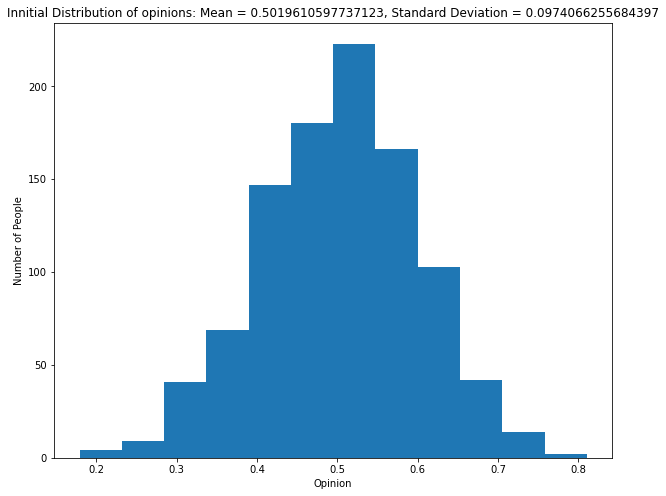

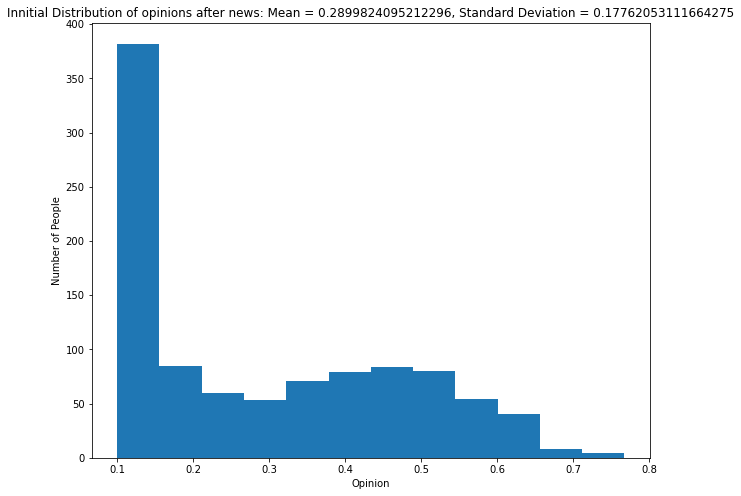

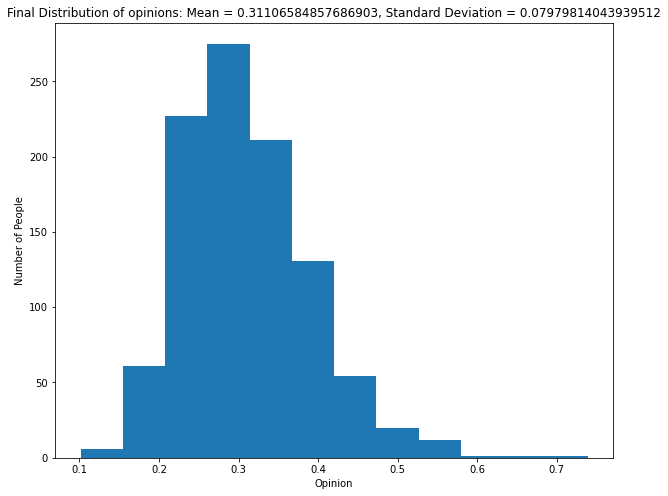

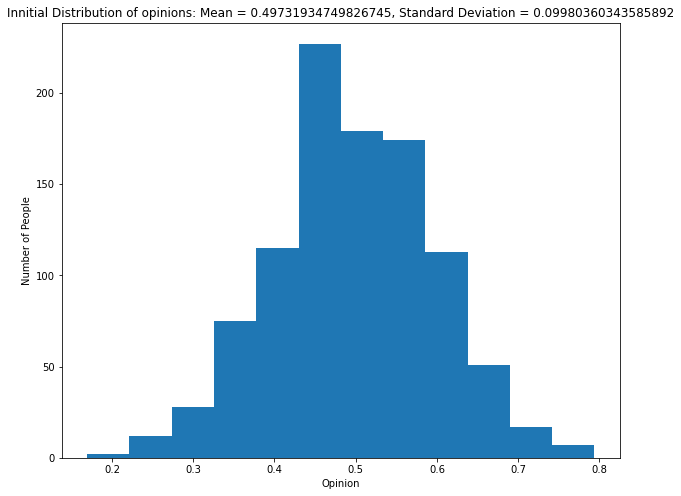

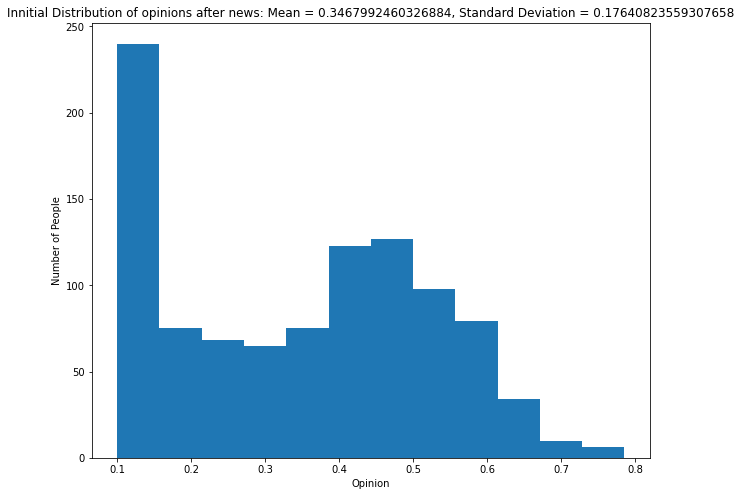

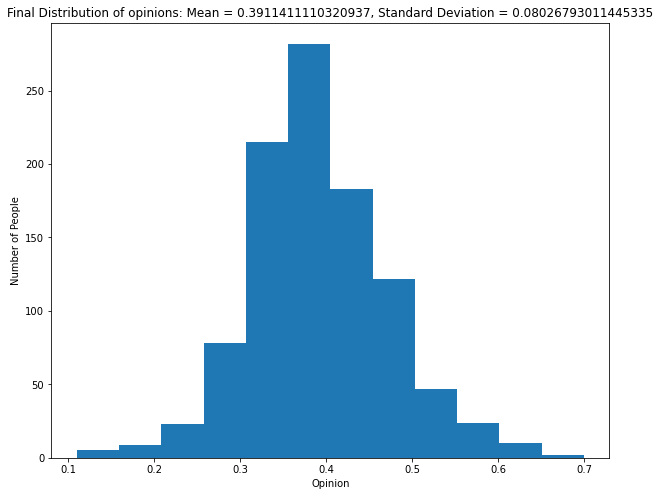

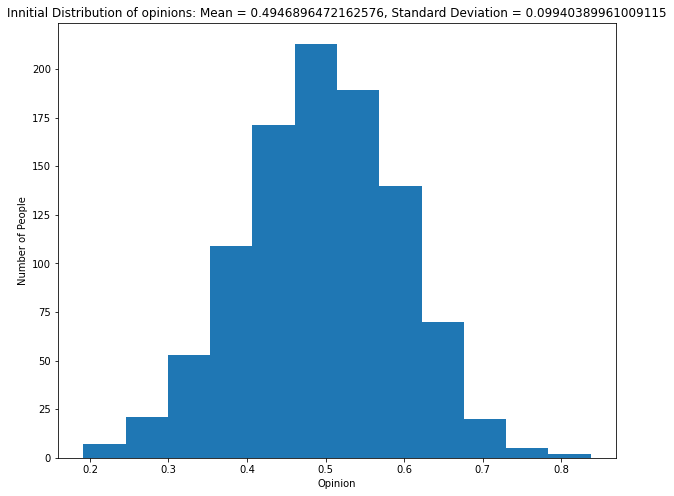

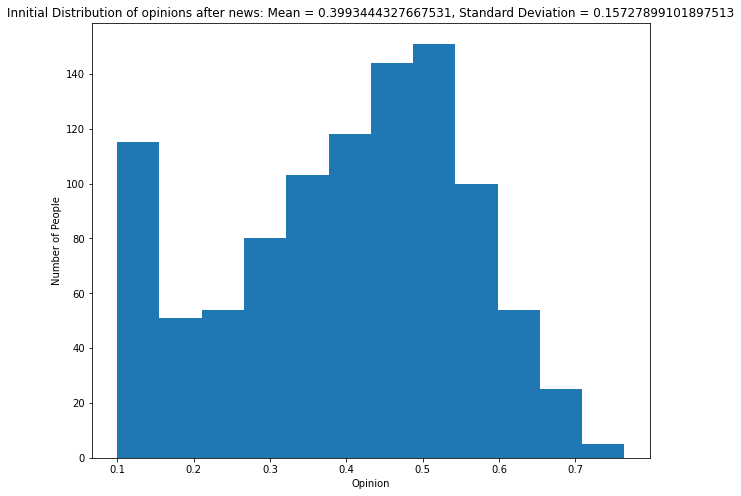

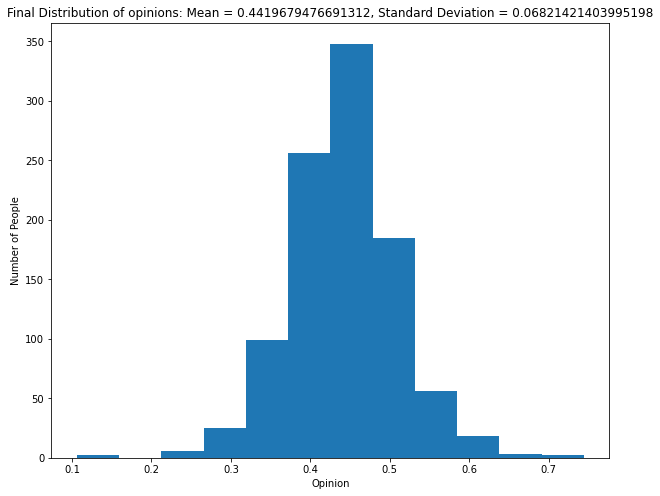

In [174]:
"""Simulation 2"""
educs = [.05, .10, .15]
for educ_scl in educs: 
    #creates a society
    pop = society_generator(1000, 
                            opinion_msd = [.5, .1],
                            opinions = "normal", 
                            opinionPeaks = 2, 
                            educ_scale = educ_scl, 
                            wtl_msd = (.8, .2), 
                            formed_scale = "off", 
                            social_msd = (.5, .2), 
                            influence_msd = (.8, .2)) 
    #pop.append(Voter(opinion = .1, educ = .1, wtl = .05, formed = .8, social = 1, influence = .8))
    newsSpace = NewsSpace() #creates a news space
    news1 = News(opinion = .1, influence = .8, credibility = .1) #creates a news article
    newsSpace.add1News(news1) #adds that news article to the news space
    news2 = News(opinion = .1, influence = .8, credibility = .1) #creates a news article
    newsSpace.add1News(news2) #adds that news article to the news space
    #newsSpace.addNews(num_of_news = 2, opinion_msd = (.1, .05), influence_msd = (.9, .05), credibility_msd = (.1, .01)) #adds a bunch of news articles to the news space
    experiment(pop, 100, newsList = newsSpace.getNews(), bins = 12, plot_each_round = "false")#runs the expiriment

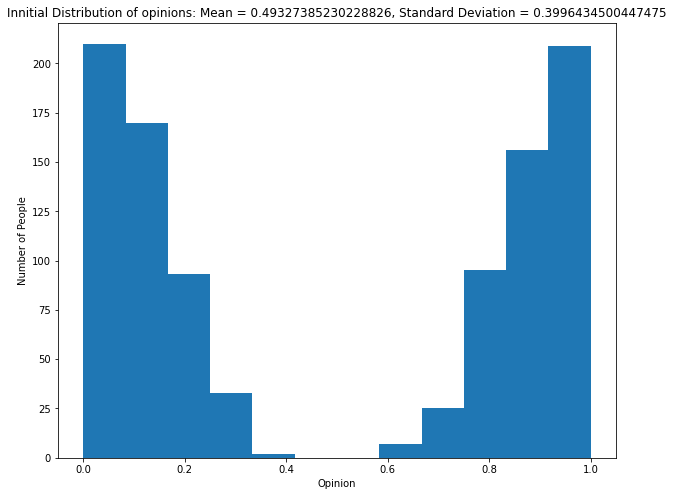

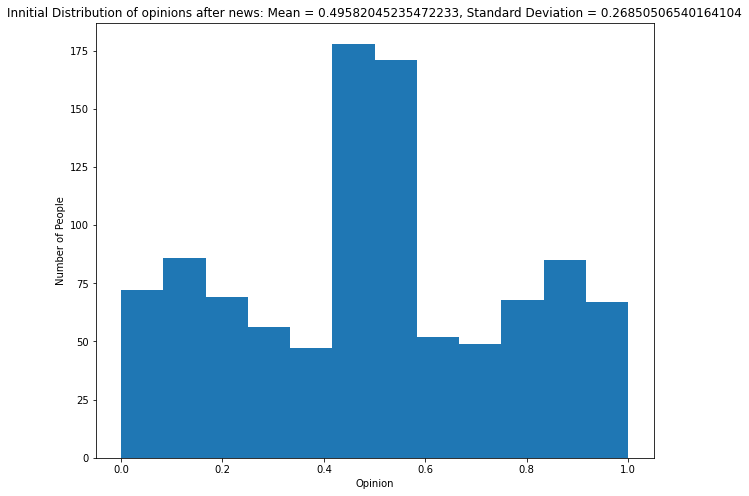

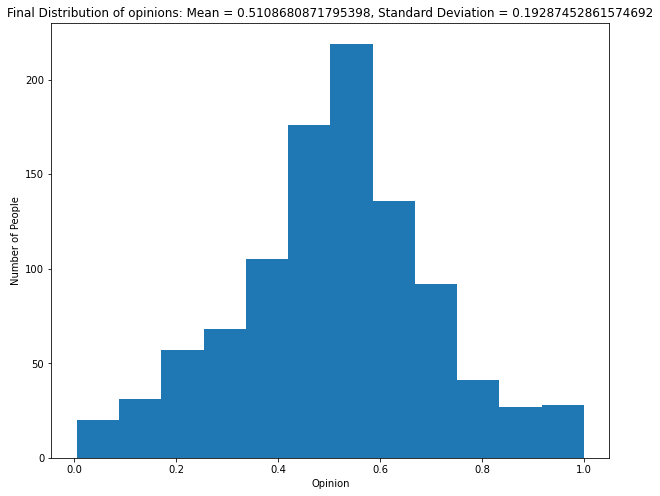

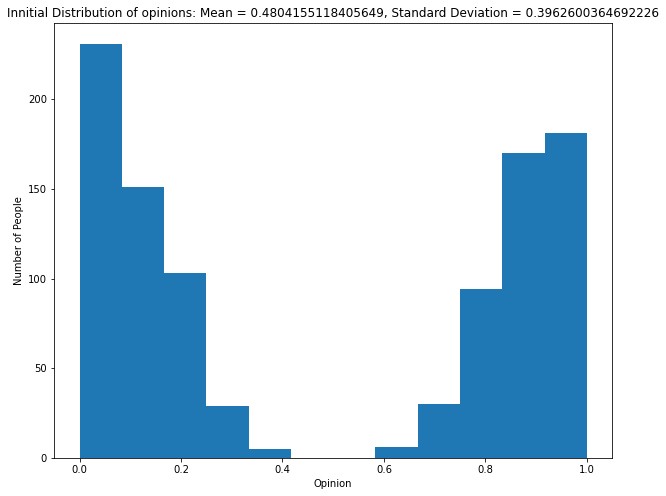

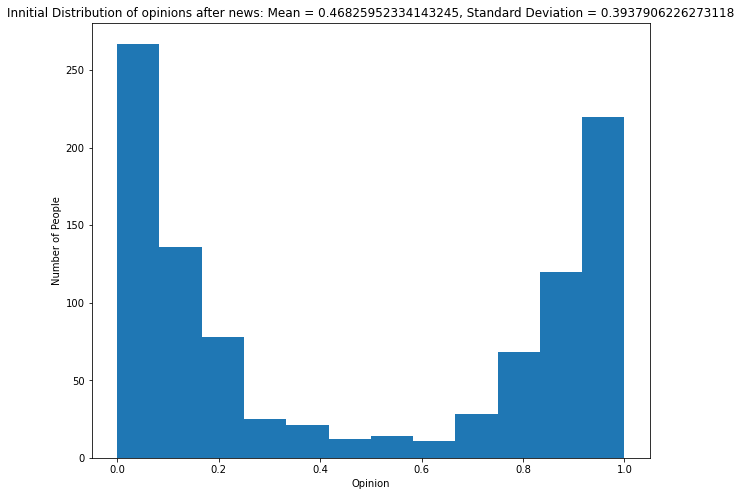

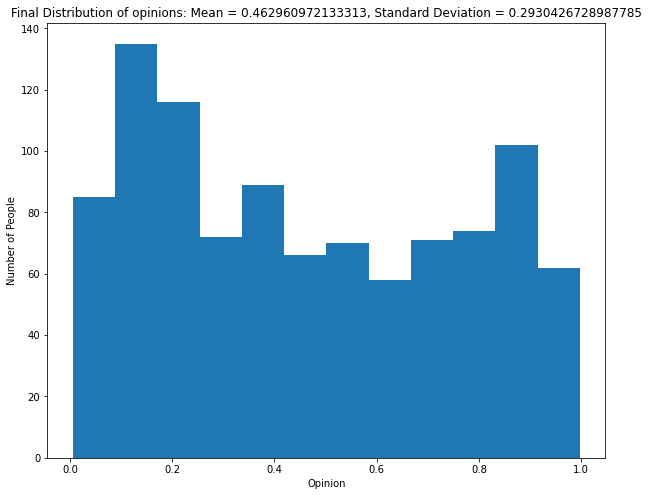

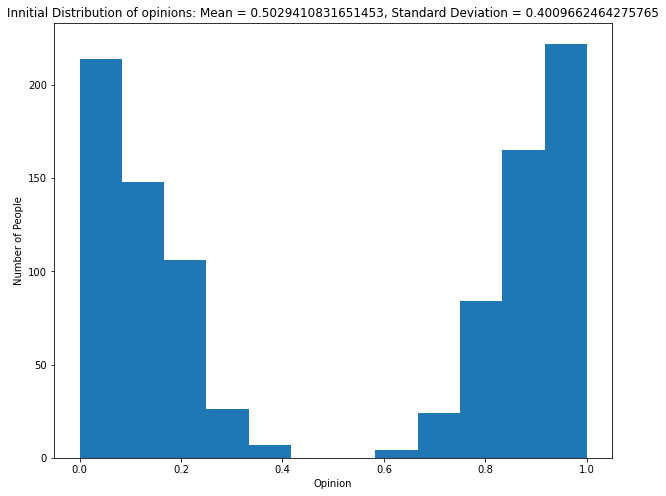

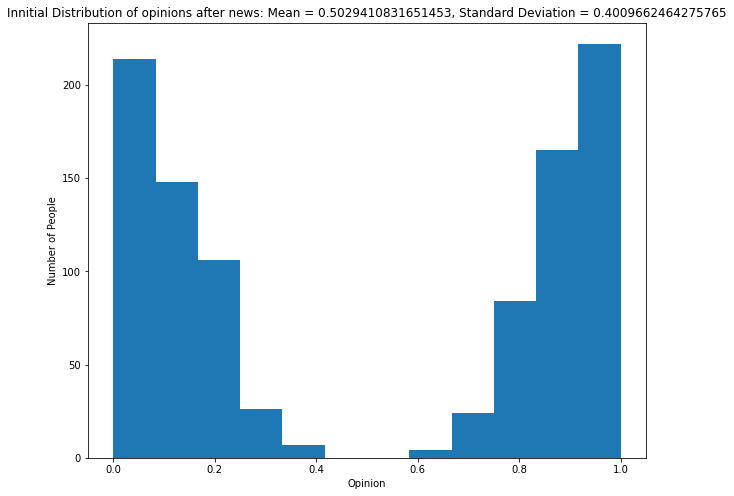

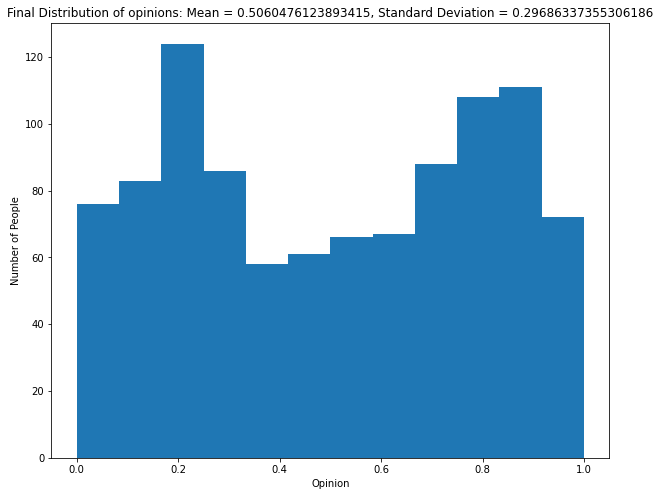

In [175]:
"""Simulation 3"""
#creates a society
newsSpace0 = NewsSpace() #creates a news space
news1 = News(opinion = .5, influence = .7, credibility = .75) #creates a news article
newsSpace0.add1News(news1) #adds that news article to the news space
news2 = News(opinion = .5, influence = .7, credibility = .75) #creates a news article
newsSpace0.add1News(news2) #adds that news article to the news space

newsSpace1 = NewsSpace() #creates a news space
news1 = News(opinion = .95, influence = .7, credibility = .75) #creates a news article
newsSpace1.add1News(news1) #adds that news article to the news space
news2 = News(opinion = .05, influence = .7, credibility = .75) #creates a news article
newsSpace1.add1News(news2) #adds that news article to the news space

newsSpace2 = NewsSpace()

spaces = [newsSpace0, newsSpace1, newsSpace2]
for space in spaces: 
    pop = society_generator(1000, 
                            opinion_msd = [[.1, .1], [.9,.1]],
                            opinions = "n-modal", 
                            opinionPeaks = 2, 
                            educ_scale = .15, 
                            wtl_msd = (.8, .2), 
                            formed_scale = "off", 
                            social_msd = (.5, .2), 
                            influence_msd = (.8, .2)) 

    experiment(pop, 50, newsList = space.getNews(), bins = 12, plot_each_round = "false")#runs the expiriment

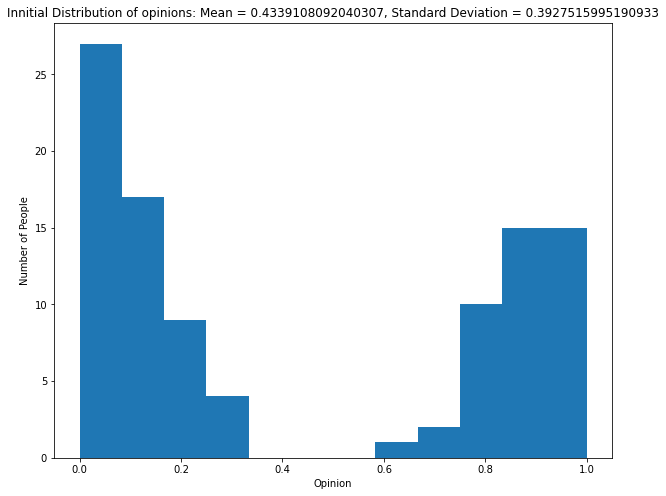

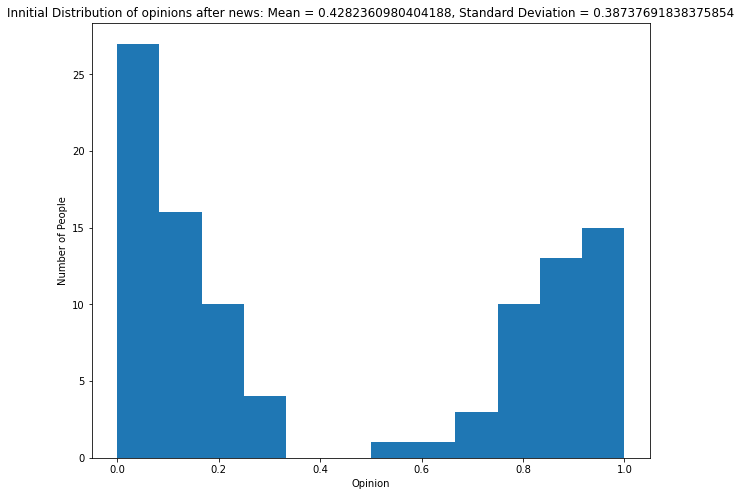

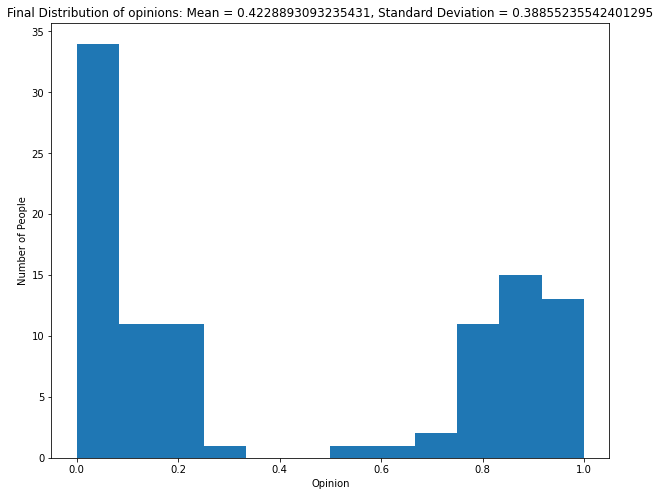

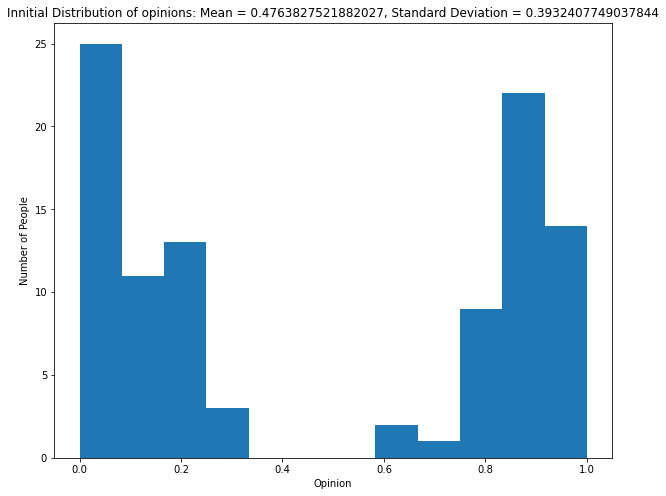

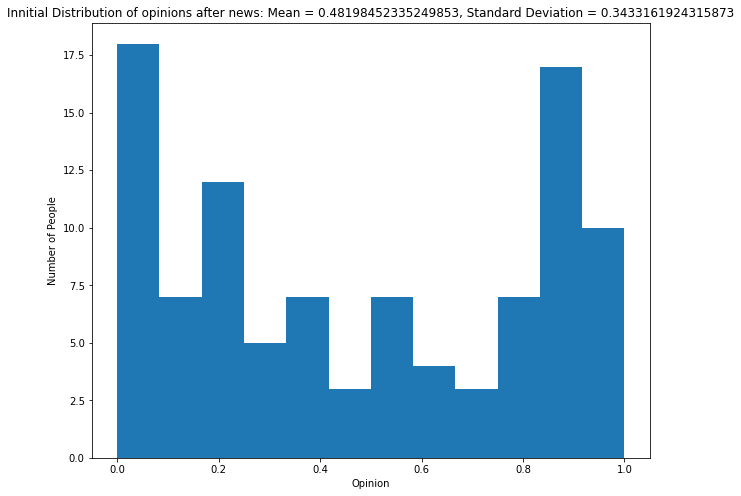

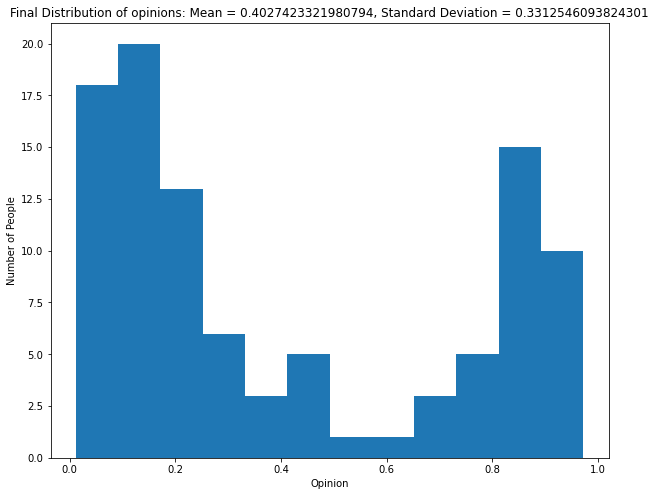

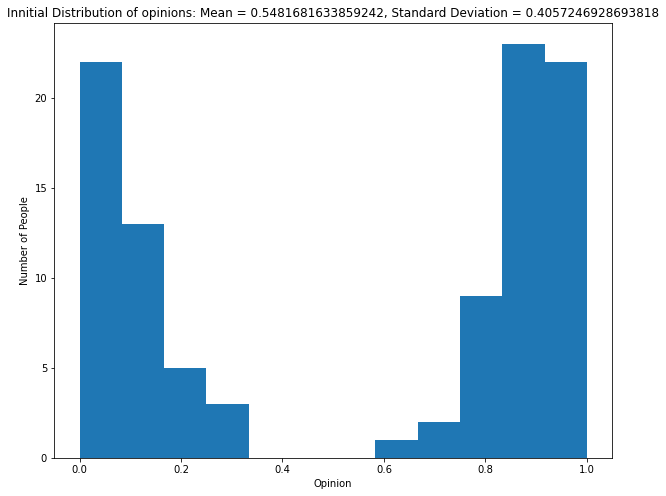

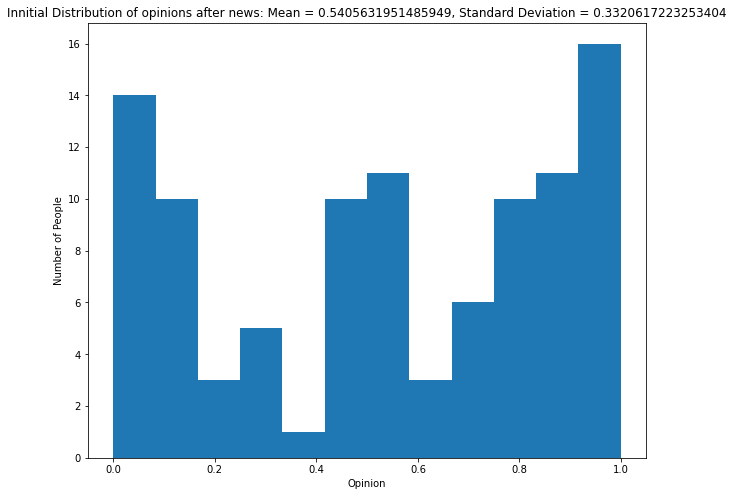

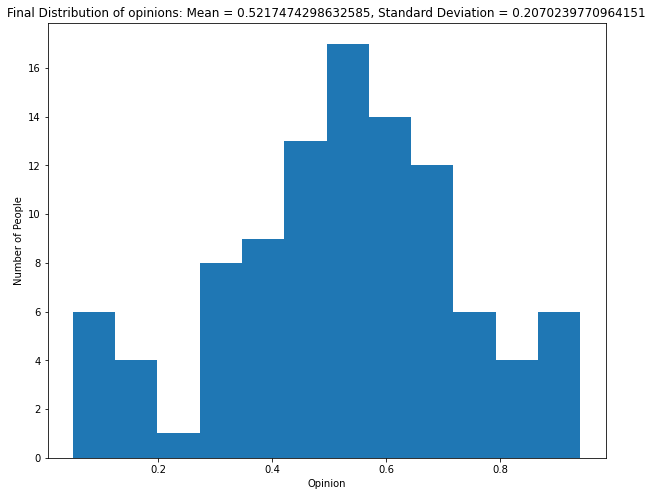

In [176]:
"""Simulation 4"""
#creates a society with the specified characheristics
wtl_radii = [.2, .5, .8]
for radius in wtl_radii: 
    pop = society_generator(100, 
                            opinion_msd = [[.1, .1], [.9,.1]],
                            opinions = "n-modal", 
                            opinionPeaks = 2, 
                            educ_scale = .15, 
                            wtl_msd = (radius, .2), 
                            formed_scale = "off", 
                            social_msd = (.5, .2), 
                            influence_msd = (.8, .2)) 
    newsSpace = NewsSpace() #creates a news space
    news = News(opinion = .5, influence = .7, credibility = .75) #creates a news article
    newsSpace.add1News(news) #adds that news article to the news space
    #newsSpace.addNews(num_of_news = 1, opinion_msd = (.5, .05), influence_msd = (.7, .1), credibility_msd = (.75, .1)) #adds a bunch of news articles to the news space
    experiment(pop, num_periods = 100, newsList = newsSpace.getNews(), bins = 12, plot_each_round = "false", plot_each_int = "false")#runs the expiriment